In [ ]:
!pip install pandas numpy matplotlib scipy plotly

<h2> Indice de Masa - Clv2 </h2>

Cargando datos...
Datos cargados: 961167 valores
Realizando regresión lineal...

RESULTADOS DEL ANÁLISIS DE ÍNDICE DE MASA
Índice de masa (s):           2.156
Pendiente de regresión:       -1.156
Intercepto:                   9.483
Coeficiente de correlación:   -0.9499
R² (bondad de ajuste):        0.9024
P-value:                      0.00e+00
Error estándar:               0.0004
Amplitud mínima:              310.00
Amplitud máxima:              43426.00
Amplitud promedio:            3705.54
Número de datos originales:   961167
Puntos usados en regresión:   961167
Rango de amplitudes:          310.00 - 43426.00
Binning aplicado:             No
✓ Excelente ajuste de la regresión
✓ Índice de masa calculado: s = 2.1561


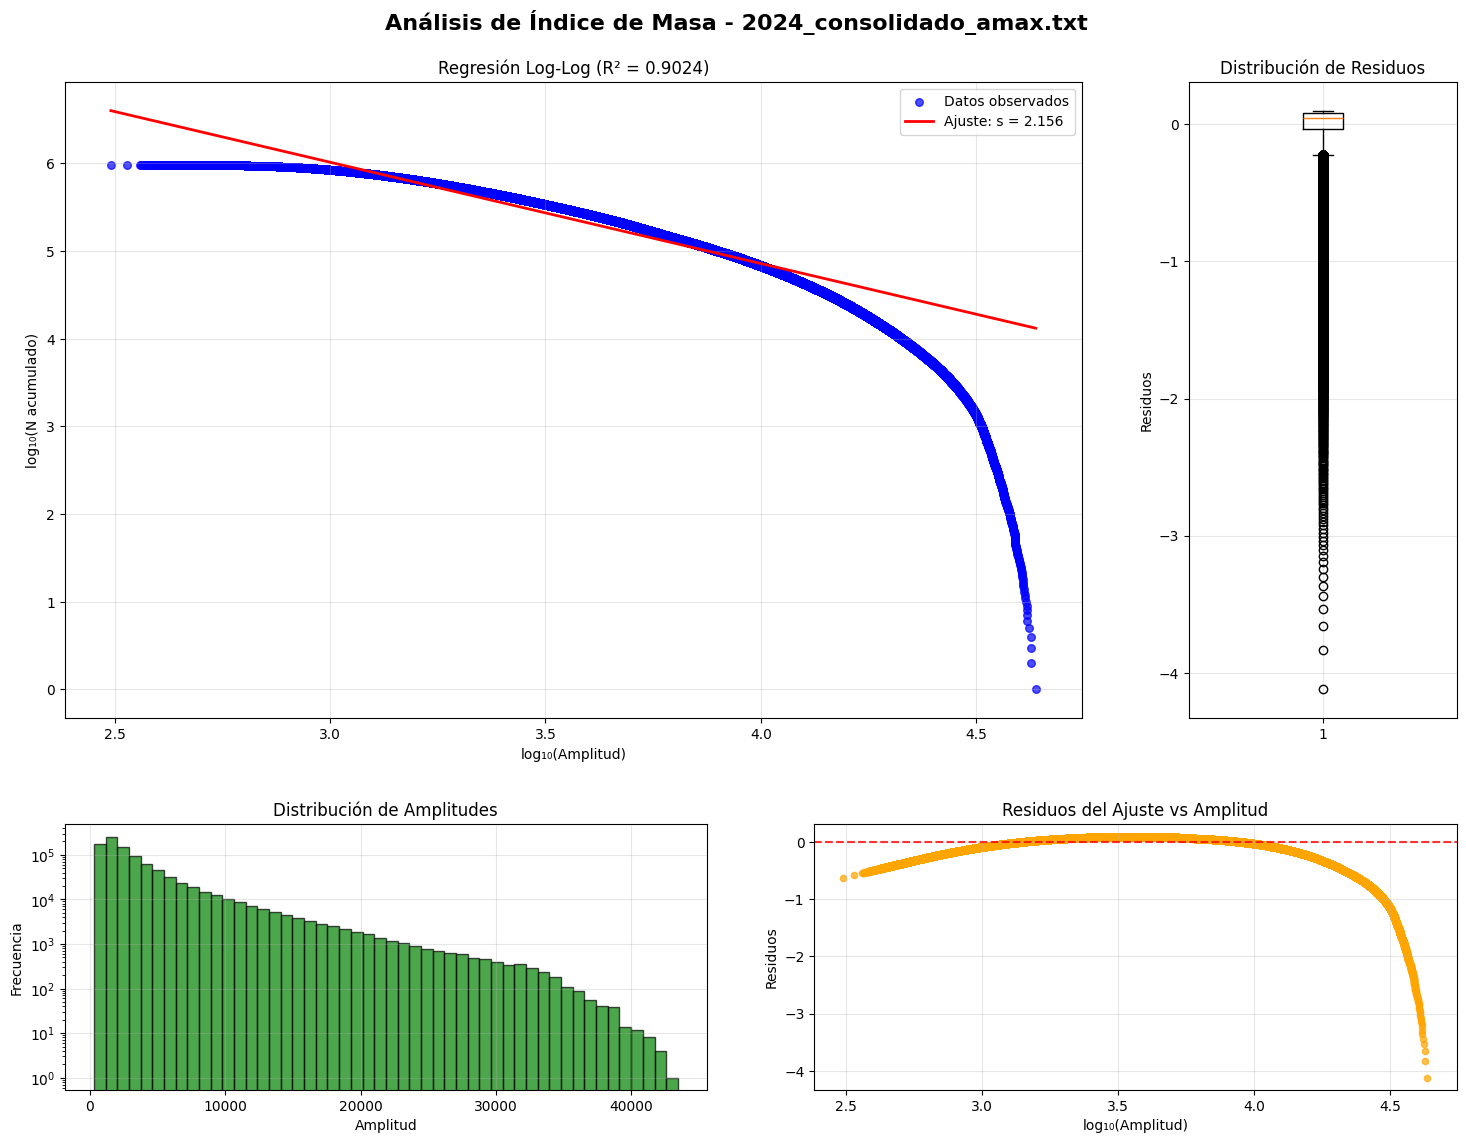

Gráfico guardado como: ../data/processed/2024_consolidado_amax_summary_analysis.png


In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def calculate_mass_index(file_path, min_amplitude=None, use_binning=False, n_bins=50):
    """
    Calcula el índice de masa de meteoritos usando el método estándar.
    
    Parámetros:
    -----------
    file_path : str
        Ruta al archivo con datos de amplitud
    min_amplitude : float, opcional
        Amplitud mínima para filtrar datos
    use_binning : bool, opcional
        Si usar binning logarítmico para reducir ruido (default: False)
    n_bins : int, opcional
        Número de bins si use_binning=True (default: 50)
    
    Retorna:
    --------
    dict : Diccionario con resultados del análisis
    """
    
    # 1. Cargar y procesar datos
    print("Cargando datos...")
    try:
        # Leer archivo (asume valores separados por espacios/líneas)
        data = np.loadtxt(file_path,dtype=str)  # Leer como texto
        data = np.char.replace(data, ",", ".").astype(float)  # Reemplazar comas y convertir a float
        amplitudes = data.flatten()  # Asegurar que sea 1D
        print(f"Datos cargados: {len(amplitudes)} valores")
    except Exception as e:
        print(f"Error al cargar archivo: {e}")
        return None
    
    # 2. Filtrar datos si se especifica amplitud mínima
    if min_amplitude is not None:
        amplitudes = amplitudes[amplitudes >= min_amplitude]
        print(f"Después del filtrado: {len(amplitudes)} valores")
    
    # Remover valores <= 0 (no válidos para log)
    amplitudes = amplitudes[amplitudes > 0]
    
    if len(amplitudes) < 10:
        print("Error: Muy pocos datos para análisis confiable")
        return None
    
    # 3. Ordenar amplitudes de mayor a menor
    amplitudes_sorted = np.sort(amplitudes)[::-1]
    
    # 4. Calcular conteo acumulado descendente (N)
    N = np.arange(1, len(amplitudes_sorted) + 1)
    
    # 5. Aplicar binning si se solicita
    if use_binning:
        print(f"Aplicando binning logarítmico con {n_bins} bins...")
        
        # Crear bins logarítmicos
        log_min = np.log10(amplitudes_sorted.min())
        log_max = np.log10(amplitudes_sorted.max())
        bin_edges = np.logspace(log_min, log_max, n_bins + 1)
        
        # Calcular valores promedio por bin
        bin_amplitudes = []
        bin_counts = []
        
        for i in range(len(bin_edges) - 1):
            mask = (amplitudes_sorted >= bin_edges[i]) & (amplitudes_sorted < bin_edges[i + 1])
            if np.sum(mask) > 0:
                bin_amplitudes.append(np.mean(amplitudes_sorted[mask]))
                bin_counts.append(np.sum(N <= np.sum(mask)))
        
        amplitudes_final = np.array(bin_amplitudes)
        N_final = np.array(bin_counts)
    else:
        amplitudes_final = amplitudes_sorted
        N_final = N
    
    # 6. Preparar datos para regresión lineal
    log_A = np.log10(amplitudes_final)
    log_N = np.log10(N_final)
    
    # 7. Realizar regresión lineal: log(N) = -(s-1) * log(A) + C
    print("Realizando regresión lineal...")
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_A, log_N)
    
    # 8. Calcular índice de masa: s = 1 - pendiente
    mass_index = 1 - slope
    
    # 9. Calcular estadísticas adicionales
    r_squared = r_value ** 2
    n_points = len(log_A)
    
    # 10. Preparar resultados
    results = {
        'mass_index': mass_index,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_squared,
        'r_value': r_value,
        'p_value': p_value,
        'std_error': std_err,
        'n_data_points': len(amplitudes),
        'n_regression_points': n_points,
        'amplitude_range': (amplitudes.min(), amplitudes.max()),
        'binning_used': use_binning,
        # Agregar datos para gráficos
        'amplitudes_original': amplitudes,
        'amplitudes_final': amplitudes_final,
        'N_final': N_final,
        'log_A': np.log10(amplitudes_final),
        'log_N': np.log10(N_final)
    }
    
    return results

def print_results(results):
    """
    Imprime los resultados del análisis de forma clara.
    """
    if results is None:
        print("No hay resultados para mostrar")
        return
    
    print("\n" + "="*50)
    print("RESULTADOS DEL ANÁLISIS DE ÍNDICE DE MASA")
    print("="*50)
    print(f"Índice de masa (s):           {results['mass_index']:.3f}")
    print(f"Pendiente de regresión:       {results['slope']:.3f}")
    print(f"Intercepto:                   {results['intercept']:.3f}")
    print(f"Coeficiente de correlación:   {results['r_value']:.4f}")
    print(f"R² (bondad de ajuste):        {results['r_squared']:.4f}")
    print(f"P-value:                      {results['p_value']:.2e}")
    print(f"Error estándar:               {results['std_error']:.4f}")
    print(f"Amplitud mínima:              {results['amplitude_range'][0]:.2f}")
    print(f"Amplitud máxima:              {results['amplitude_range'][1]:.2f}")
    print(f"Amplitud promedio:            {results['amplitudes_original'].mean():.2f}")
    print(f"Número de datos originales:   {results['n_data_points']}")
    print(f"Puntos usados en regresión:   {results['n_regression_points']}")
    print(f"Rango de amplitudes:          {results['amplitude_range'][0]:.2f} - {results['amplitude_range'][1]:.2f}")
    print(f"Binning aplicado:             {'Sí' if results['binning_used'] else 'No'}")
    print("="*50)
    
    # Interpretación básica
    if results['r_squared'] > 0.8:
        print("✓ Excelente ajuste de la regresión")
    elif results['r_squared'] > 0.6:
        print("✓ Buen ajuste de la regresión")
    else:
        print("⚠ Ajuste de regresión podría mejorarse")
    
    print(f"✓ Índice de masa calculado: s = {results['mass_index']:.4f}")

def create_summary_plot(results, amplitudes_original, amplitudes_final, N_final, file_path):
    """
    Crea un gráfico resumen con grilla personalizada 4 columnas x 3 filas.
    Incluye título y funcionalidad de guardado.
    """
    if results is None:
        print("No hay resultados para graficar")
        return
    
    # Crear figura con grilla personalizada
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 4, figure=fig, hspace=0.4, wspace=0.4)
    
    # 1. Línea de ajuste (3x2 = ocupa 3 columnas y 2 filas)
    ax1 = fig.add_subplot(gs[0:2, 0:3])  # filas 0-1, columnas 0-2
    log_A = np.log10(amplitudes_final)
    log_N = np.log10(N_final)
    
    # Datos observados
    ax1.scatter(log_A, log_N, alpha=0.7, s=30, color='blue', label='Datos observados')
    
    # Línea de ajuste
    A_fit = np.linspace(log_A.min(), log_A.max(), 100)
    N_fit = results['slope'] * A_fit + results['intercept']
    ax1.plot(A_fit, N_fit, 'r-', linewidth=2, label=f'Ajuste: s = {results["mass_index"]:.3f}')
    
    ax1.set_xlabel('log₁₀(Amplitud)')
    ax1.set_ylabel('log₁₀(N acumulado)')
    ax1.set_title(f'Regresión Log-Log (R² = {results["r_squared"]:.4f})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribución de residuos (1x2 = 1 columna, 2 filas)
    ax2 = fig.add_subplot(gs[0:2, 3])  # filas 0-1, columna 3
    predicted = results['slope'] * log_A + results['intercept']
    residuals = log_N - predicted
    ax2.boxplot(residuals, vert=True)
    ax2.set_ylabel('Residuos')
    ax2.set_title('Distribución de Residuos')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribución de amplitudes (2x1 = 2 columnas, 1 fila)
    ax3 = fig.add_subplot(gs[2, 0:2])  # fila 2, columnas 0-1
    ax3.hist(amplitudes_original, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax3.set_xlabel('Amplitud')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de Amplitudes')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # 4. Residuos del ajuste (2x1 = 2 columnas, 1 fila)
    ax4 = fig.add_subplot(gs[2, 2:4])  # fila 2, columnas 2-3
    ax4.scatter(log_A, residuals, alpha=0.7, s=20, color='orange')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax4.set_xlabel('log₁₀(Amplitud)')
    ax4.set_ylabel('Residuos')
    ax4.set_title('Residuos del Ajuste vs Amplitud')
    ax4.grid(True, alpha=0.3)
    
    # Título general
    fig.suptitle(f'Análisis de Índice de Masa - {file_path.split("/")[-1]}', 
                 fontsize=16, fontweight='bold')
    
    # Usar subplots_adjust en lugar de tight_layout para evitar warnings
    plt.subplots_adjust(left=0.08, bottom=0.08, right=0.95, top=0.92, 
                       wspace=0.3, hspace=0.4)
    
    plt.show()
    
    # Guardar figura
    output_name = file_path.replace('.txt', '_summary_analysis.png')
    fig.savefig(output_name, dpi=300, bbox_inches='tight')
    print(f"Gráfico guardado como: {output_name}")

# Función principal de uso
def analyze_meteorite_mass_index(file_path, **kwargs):
    """
    Función principal para analizar el índice de masa.
    
    Ejemplo de uso:
    results = analyze_meteorite_mass_index('Test/2024amaxT.txt')
    """
    results = calculate_mass_index(file_path, **kwargs)
    print_results(results)
    
    # Crear gráfico resumen si los resultados son válidos
    if results is not None:
        create_summary_plot(results, results['amplitudes_original'],
                           results['amplitudes_final'], results['N_final'], file_path)
    
    return results

# Ejemplo de uso
if __name__ == "__main__":
    # Uso básico
    results = analyze_meteorite_mass_index('../data/processed/2024_consolidado_amax.txt')
    
    # Uso con filtrado
    # results = analyze_meteorite_mass_index('Test/2024amax.txt', min_amplitude=10.0)
    
    # Uso con binning
    # results = analyze_meteorite_mass_index('Test/2024amax.txt', use_binning=True, n_bins=30)

<h2>IM ChatGPT</h2>

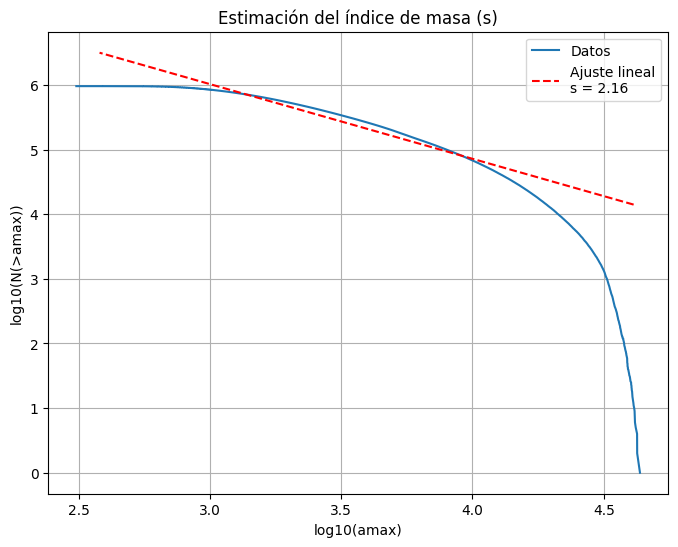

Índice de masa estimado: 2.1558


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def calcular_indice_masa(csv_path, columna_amplitud='amax', graficar=True):
    # Leer el CSV con separador ';'
    df = pd.read_csv(csv_path, sep=';')

    # Convertir la columna de amplitud a numérica y eliminar valores no válidos o negativos
    df[columna_amplitud] = pd.to_numeric(df[columna_amplitud].str.replace(',', '.'), errors='coerce')
    df = df.dropna(subset=[columna_amplitud])
    df = df[df[columna_amplitud] > 0]

    # Ordenar las amplitudes de mayor a menor
    amplitudes = np.sort(df[columna_amplitud].values)[::-1]
    N = np.arange(1, len(amplitudes) + 1)

    # Log-log
    logA = np.log10(amplitudes)
    logN = np.log10(N)

    # Ajuste lineal en la región lineal (puede ajustarse este filtro según la forma del gráfico)
    idx_inicio = 10  # evitar los primeros puntos que pueden saturar
    idx_fin = len(logA) - 10  # evitar la cola
    slope, intercept, r_value, p_value, std_err = linregress(logA[idx_inicio:idx_fin], logN[idx_inicio:idx_fin])

    s = 1 - slope  # relación N(>A) ~ A^{1-s}

    if graficar:
        plt.figure(figsize=(8,6))
        plt.plot(logA, logN, label='Datos')
        plt.plot(logA[idx_inicio:idx_fin], slope * logA[idx_inicio:idx_fin] + intercept, 'r--', label=f'Ajuste lineal\ns = {s:.2f}')
        plt.xlabel('log10(amax)')
        plt.ylabel('log10(N(>amax))')
        plt.title('Estimación del índice de masa (s)')
        plt.legend()
        plt.grid(True)
        plt.show()

    return s
s = calcular_indice_masa('../data/processed/2024_consolidado.csv')
print(f'Índice de masa estimado: {s:.4f}')